<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pathway-analysis" data-toc-modified-id="Pathway-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pathway analysis</a></span></li><li><span><a href="#Pathway-aggregation" data-toc-modified-id="Pathway-aggregation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pathway aggregation</a></span></li><li><span><a href="#Retrieve-compounds-and-pathways" data-toc-modified-id="Retrieve-compounds-and-pathways-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Retrieve compounds and pathways</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import biom
import arviz as az
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial.distance import euclidean
import seaborn as sns

from util import ranking, btest, read_kegg_dict
%matplotlib inline

In [2]:
fname = '../sfari/data/sra_shotgun/Combined/age_sex_matched_posterior/differential_posterior.nc'
posterior = az.from_netcdf(fname)

name = 'Shotgun_combined'
x = posterior['posterior']['diff'].to_dataframe().reset_index().pivot(
    index='features', columns=['chain', 'draw'], values='diff')

lr = ranking(x)

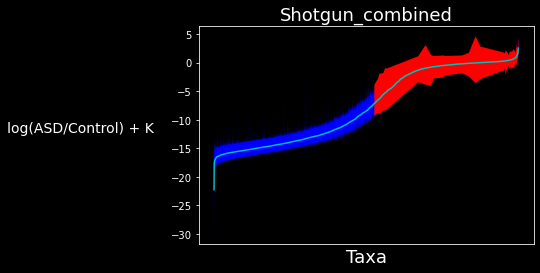

<Figure size 432x288 with 0 Axes>

In [14]:
genes = defaultdict()
plt.style.use('dark_background')
lr = lr.sort_values('effect_size')
threshold = 1e-3 / len(lr)
cond = np.logical_and(lr['pvalue'] < threshold, lr['effect_size'] > 0)
genes[name] = lr.loc[cond]  # top ASD microbes
genes[name] = genes[name].sort_values('effect_size')
idx = np.arange(len(lr))
lr = lr.sort_values('mean')
cmap = matplotlib.cm.get_cmap('seismic')
# norm = matplotlib.colors.Normalize(vmin=min(lr['prob_lr']), vmax=max(lr['prob_lr']))
norm = matplotlib.colors.TwoSlopeNorm(
    vmin=min(lr['prob_lr']), vcenter=0., vmax=max(lr['prob_lr']))
lr['index'] = idx
plt.fill_between(lr['index'], lr['5%'], lr['95%'], fc='b')
idx = np.logical_and(lr['prob_lr'] > 0, lr['effect_size'] > 0)
i = np.logical_and(lr['pvalue'] < threshold, idx)
plt.fill_between(lr.loc[i, 'index'], lr.loc[i, '5%'], lr.loc[i, '95%'], fc='r')
plt.plot(lr['index'], lr['mean'], c='c')
plt.xlabel('Taxa', fontsize=18)
plt.xticks([])
plt.title(name, fontsize=18)
plt.ylabel('log(ASD/Control) + K', labelpad=90, rotation=0, fontsize=14)
#plt.colorbar(cbar)
plt.show()
plt.tight_layout()

In [4]:
from q2_matchmaker._stats import hotelling_ttest, spherical_test
spherical_test(x.values.T)

(False, 41.73885485826829, 422.33191282733804)

# Pathway analysis

In [5]:
idx1 = lr['pvalue'] < 0.001 / len(lr) # boniferroni correction
idx2 = np.logical_and(lr['prob_lr'] > 0, lr['effect_size'] > 0)
idx3 = np.logical_and(lr['prob_lr'] < 0, lr['effect_size'] < 0)

shotgun_asd = lr.loc[np.logical_and(idx1, idx2)]
shotgun_con = lr.loc[np.logical_and(idx1, idx3)]

In [6]:
from biom import load_table
from scipy.sparse import coo_matrix

func_table = load_table('../sfari/data/sra_shotgun/Combined/table_func.biom')

func_ids = func_table.ids(axis='observation')
func_df = pd.DataFrame(list(map(lambda x: x.split('|'), func_ids)))

# convert to sparse matrix for convenience
func_df.columns = ['OGU', 'KEGG']
func_df['count'] = 1
ogus = list(set(func_df['OGU']))
ogu_lookup = dict(zip(list(set(ogus)), range(len(ogus))))
keggs = list(set(func_df['KEGG']))
kegg_lookup = dict(zip(list(set(keggs)), range(len(keggs))))
func_df['OGU_id'] = func_df['OGU'].apply(lambda x: ogu_lookup[x]).astype(np.int64)
func_df['KEGG_id'] = func_df['KEGG'].apply(lambda x: kegg_lookup[x]).astype(np.int64)
c, i, j = func_df['count'].values, func_df['OGU_id'].values, func_df['KEGG_id'].values
data = coo_matrix((c, (i, j)))

ko_ogu = pd.DataFrame(data.todense(), index=ogus, columns=keggs)

# apparently OGUs don't always overlap with the stratified output
shotgun_asd_idx = set(ko_ogu.index) & set(shotgun_asd.index)
shotgun_con_idx = set(ko_ogu.index) & set(shotgun_con.index)

asd_microbes = ko_ogu.loc[shotgun_asd_idx].index
con_microbes = ko_ogu.loc[shotgun_con_idx].index

kegg_con_WGS, kegg_asd_WGS = btest(
    ko_ogu.reindex(asd_microbes).dropna(), 
    ko_ogu.reindex(con_microbes).dropna())    

kegg_asd_WGS = kegg_asd_WGS.reset_index()
kegg_asd_WGS.columns = ['KEGG', 'pvalue']
kegg_asd_WGS['-log(pvalue)'] = -np.log(kegg_asd_WGS['pvalue'] + 1e-200)

In [7]:
threshold = (0.001 / len(kegg_asd_WGS))
kegg_asd_WGS = kegg_asd_WGS.loc[kegg_asd_WGS['pvalue'] < threshold]

In [8]:
kegg_asd_WGS.to_csv('../results/WGS_KEGG.csv')

# Pathway aggregation

In [9]:
kegg_dir = '../results/kegg'

pwy2kegg = read_kegg_dict(f'{kegg_dir}/pathway-to-ko.txt', 
                          ['Pathway', 'KO'])

pwy_name = pd.read_table(f'{kegg_dir}/pathway_name.txt', header=None)
pwy_name.columns = ['Pathway', 'Name']
pwy2kegg = pd.merge(pwy2kegg, pwy_name, left_on='Pathway', right_on='Pathway')

lookup = {d: i for i, d in enumerate(pwy2kegg['Name'].value_counts().index)}
pwy2kegg['ID'] = pwy2kegg['Name'].apply(lambda x: lookup[x])

In [10]:
sig_WGS = kegg_asd_WGS
sig_WGS = pd.merge(pwy2kegg, sig_WGS, left_on='KO', right_on='KEGG').drop_duplicates()
pwy2kegg = pwy2kegg.set_index('Pathway')

In [11]:
sig_WGS['Name'].value_counts()

ABC transporters               186
Two-component system           158
Purine metabolism               75
Quorum sensing                  66
Pyruvate metabolism             55
                              ... 
IL-17 signaling pathway          1
Prolactin signaling pathway      1
Viral carcinogenesis             1
Yersinia infection               1
Mineral absorption               1
Name: Name, Length: 230, dtype: int64

# Retrieve compounds and pathways

In [12]:
pwy2compound = read_kegg_dict(f'{kegg_dir}/pathway-to-compound.txt', 
                              ['Pathway', 'Compound'])
sig_WGS = pd.merge(sig_WGS, pwy2compound, left_on='Pathway', right_on='Pathway')
sig_WGS.to_csv('../results/WGS_compounds.csv')

In [13]:
sig_WGS.shape

(125916, 8)